In [1]:
import SiemensQuadraProperties as sqp
import ExplorerProperties as ep
from ActivityTools import *
from SimulationDataset import *

import matplotlib.pyplot as mpl
params = {'legend.fontsize': 15,
          'legend.title_fontsize': 15,
          'legend.loc': "upper left",
          'axes.labelsize': 15,
          'xtick.labelsize': 15,
          'ytick.labelsize': 15}
mpl.rcParams.update(params)

#Fix random seed for reproducibility, or skip this to allow the results to vary
import random
random.seed( 1234 )

Calculate NECR versus time as an F18 linear source decays from an initial 1100MBq activity (plotted activity is divided by the cylindrical phantom volume in cc).

Statistical fluctuation of the result can be reduced by increasing the simulationWindow parameter, at the cost of CPU time. The size of the simulated dataset can also be increased, but this has a lesser effect for counting experiments.

The CreateDataset command will run the Geant4 simulation with the appropriate parameters for source and detector type and length. The requested number of events will be simulated, but only those within the specified energy window will be loaded for analysis. If a suitable dataset already exists it will be re-used without further simulation.

In [2]:
def NECRatTimeF18( detectorMaterial, tracerData, crystalData, crystalActivity, detectorRadius, phantomLength, simulationWindow=1E-2, coincidenceWindow=4.7E-9, zWindow=325.0 ):
    # get volume in cc
    phantomRadius = 20.3 / 2.0
    phantomVolume = phantomRadius * phantomRadius * math.pi * phantomLength / 10.0 # assume length in mm
    
    necrAtTime = []
    trueAtTime = []
    rPlusSAtTime = []
    activityAtTime = []
    scattersAtTime = []
    randomsAtTime = []
    
    

    for time in range( 0, 700, 20 ):
        timeSec = float(time) * 60.0
        activity = F18ActivityAtTime( 1100E6, timeSec )

        activityList = []
        dataList = []
        if detectorMaterial == "LSO" or detectorMaterial == "LYSO":
            activityList = [activity, crystalActivity]
            dataList = [tracerData, crystalData]
        else :
            activityList = [activity]
            dataList = [tracerData]
        
        necr, true, rPlusS, Scatters, Randoms = DetectedCoincidences( activityList, dataList, simulationWindow, coincidenceWindow, detectorRadius, ZMin=-zWindow, ZMax=zWindow )
        necrAtTime.append( necr )
        trueAtTime.append( true )
        rPlusSAtTime.append( rPlusS )
        scattersAtTime.append( Scatters )
        randomsAtTime.append( Randoms )
        activityAtTime.append( activity / phantomVolume )
    
    return activityAtTime, necrAtTime, trueAtTime, rPlusSAtTime, scattersAtTime, randomsAtTime

# Simulation parameters
phantomLength = 700
datasetSize = 1000000
siemensEmin = 435.0
siemensEmax = 585.0
explorerEmin = 430.0
explorerEmax = 645.0

detectorMaterial = "LSO"
tracerData = CreateDataset( 1024, "Siemens", phantomLength, "LinearF18", datasetSize, siemensEmin, siemensEmax, detectorMaterial )
crystalData = None
if detectorMaterial == "LSO" or detectorMaterial == "LYSO":
    crystalData = CreateDataset( 1024, "Siemens", phantomLength, "Siemens", datasetSize, siemensEmin, siemensEmax, detectorMaterial )

activityAtTimeSiemens, necrAtTimeSiemens, trueAtTimeSiemens, rPlusSAtTimeSiemens, scatterAtTimeSiemens, randomAtTimeSiemens = NECRatTimeF18( detectorMaterial, tracerData, crystalData, sqp.Lu176decaysInMass( sqp.DetectorMass(detectorMaterial) ), sqp.DetectorRadius(), phantomLength )
# Calculate scatter fraction defined as S/(S+T)
SFDenominatorAtTimeSiemens = [sum(n) for n in zip(trueAtTimeSiemens, scatterAtTimeSiemens)]
SFAtTimeSiemens = np.divide(scatterAtTimeSiemens, SFDenominatorAtTimeSiemens)
meanSFSiemens = np.mean(SFAtTimeSiemens)
print("Mean Scatter fraction for Siemens: ", meanSFSiemens)
mpl.clf()

detectorMaterial = "LYSO"
tracerData = CreateDataset( 1850, "Explorer", phantomLength, "LinearF18", datasetSize, explorerEmin, explorerEmax, detectorMaterial )

crystalData = None
if detectorMaterial == "LSO" or detectorMaterial == "LYSO":
    crystalData = CreateDataset( 1850, "Explorer", phantomLength, "Explorer", datasetSize, explorerEmin, explorerEmax, detectorMaterial )

activityAtTimeExplorer, necrAtTimeExplorer, trueAtTimeExplorer, rPlusSAtTimeExplorer, scatterAtTimeExplorer, randomAtTimeExplorer = NECRatTimeF18( detectorMaterial, tracerData, crystalData, ep.Lu176decaysInMass( ep.DetectorMass(detectorMaterial)), ep.DetectorRadius(), phantomLength )
SFDenominatorAtTimeExplorer = [sum(n) for n in zip(trueAtTimeExplorer, scatterAtTimeExplorer)]
SFAtTimeExplorer = np.divide(scatterAtTimeExplorer, SFDenominatorAtTimeExplorer)
meanSFExplorer = np.mean(SFAtTimeExplorer)
print("Mean scatter fraction for Explorer: ", meanSFExplorer)
mpl.clf()

Re-using previous simulation
347905.0 events loaded (1000000 simulated) with average 1.1452436728417241 hits/event
Re-using previous simulation
107818.0 events loaded (1000000 simulated) with average 1.0077630822311674 hits/event
Mean Scatter fraction for Siemens:  0.3506364217086629
Re-using previous simulation
386285.0 events loaded (1000000 simulated) with average 1.155292077093338 hits/event
Re-using previous simulation
234399.0 events loaded (1000000 simulated) with average 1.0006655318495385 hits/event
Mean scatter fraction for Explorer:  0.3536898313744221


<Figure size 640x480 with 0 Axes>

Compare the results for both Siemens Quadra and EXPLORER detectors at their default aFOV values, for a 700mm phantom.

Note that the NEMA NU 2-2012 standard specifies a 650mm window from which to accept hits

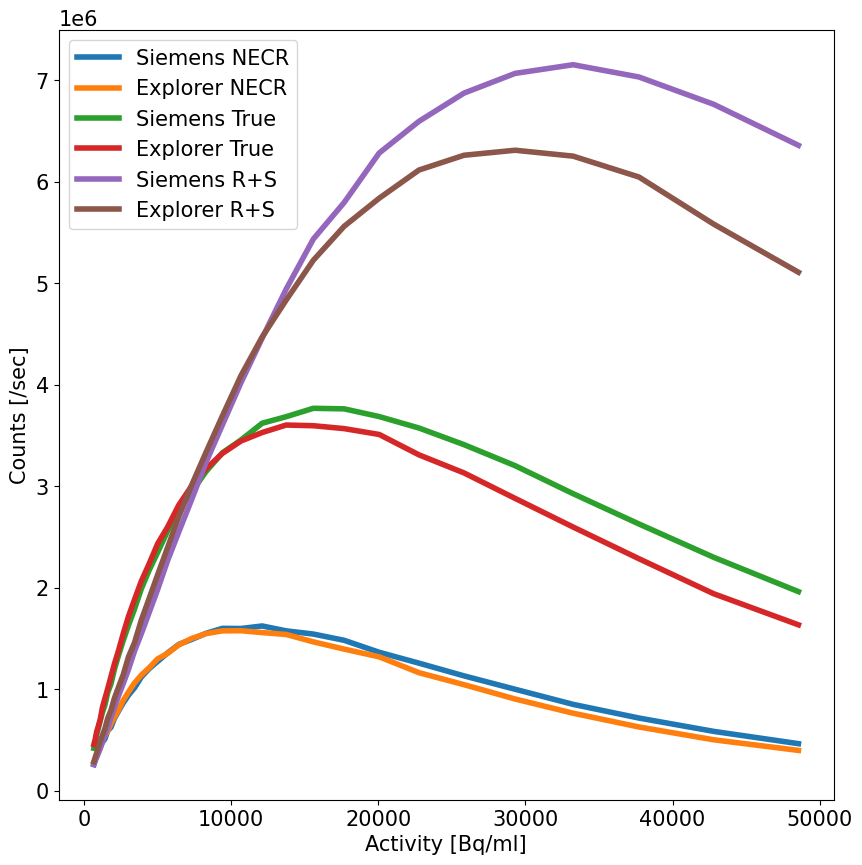

In [3]:
labels = [ "Siemens NECR", "Explorer NECR", "Siemens True", "Explorer True", "Siemens R+S", "Explorer R+S" ]
mpl.plot( activityAtTimeSiemens, necrAtTimeSiemens, label=labels[0], linewidth=4.0 )
mpl.plot( activityAtTimeExplorer, necrAtTimeExplorer, label=labels[1], linewidth=4.0 )
mpl.plot( activityAtTimeSiemens, trueAtTimeSiemens, label=labels[2], linewidth=4.0 )
mpl.plot( activityAtTimeExplorer, trueAtTimeExplorer, label=labels[3], linewidth=4.0 )
mpl.plot( activityAtTimeSiemens, rPlusSAtTimeSiemens, label=labels[4], linewidth=4.0 )
mpl.plot( activityAtTimeExplorer, rPlusSAtTimeExplorer, label=labels[5], linewidth=4.0 )
mpl.legend( labels )
mpl.xlabel( "Activity [Bq/ml]" )
mpl.ylabel( "Counts [/sec]" )
mpl.gcf().set_size_inches(10, 10)
mpl.show()

Use the data above to create a plot comparable with the experimental result in Figure 3A of https://jnm.snmjournals.org/content/early/2020/10/23/jnumed.120.250597

Spencer BA, Berg E, Schmall JP, Omidvari N, Leung EK, Abdelhafez YG, Tang S, Deng Z, Dong Y, Lv Y, Bao J. Performance evaluation of the uEXPLORER total-body PET/CT scanner based on NEMA NU 2-2018 with additional tests to characterize PET scanners with a long axial field of view. Journal of Nuclear Medicine. 2021 Jun 1;62(6):861-70.

Note that the corresponding curves have broadly similar shapes and values, but the simulated results appear to reach a maximum value before the experimental ones do

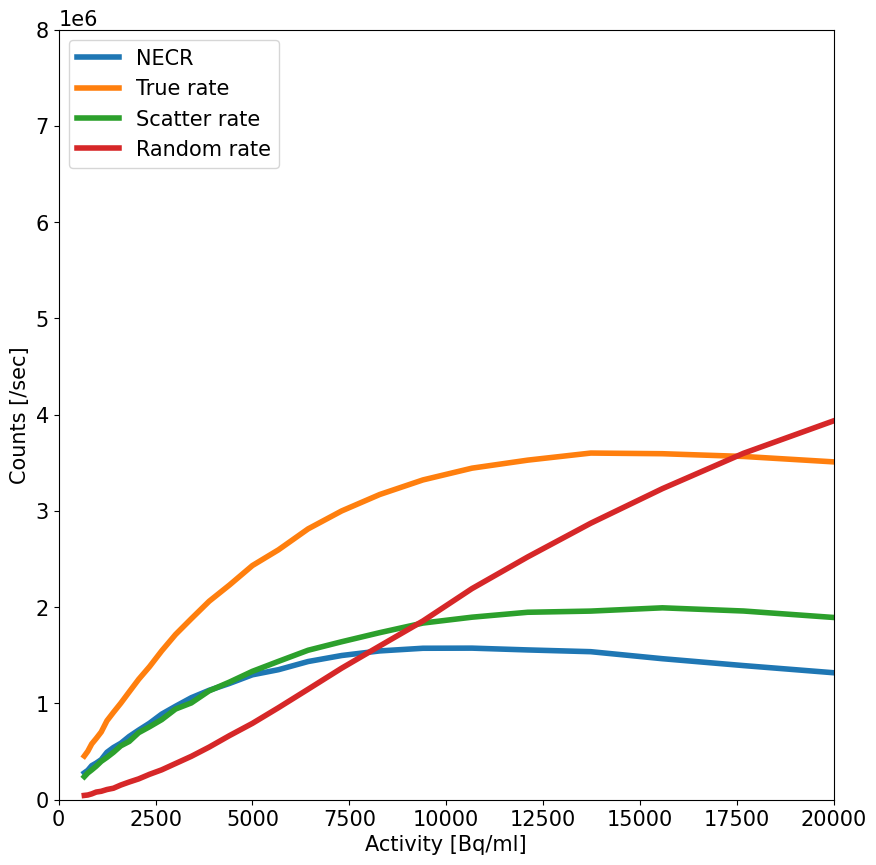

In [4]:
labels = [ "NECR", "True rate", "Scatter rate", "Random rate" ]
mpl.plot( activityAtTimeExplorer, necrAtTimeExplorer, label=labels[0], linewidth=4.0 )
mpl.plot( activityAtTimeExplorer, trueAtTimeExplorer, label=labels[1], linewidth=4.0 )
mpl.plot( activityAtTimeExplorer, scatterAtTimeExplorer, label=labels[2], linewidth=4.0 )
mpl.plot( activityAtTimeExplorer, randomAtTimeExplorer, label=labels[3], linewidth=4.0 )
mpl.legend( labels )
mpl.xlabel( "Activity [Bq/ml]" )
mpl.xlim( [ 0, 20000 ] )
mpl.ylim( [ 0, 8000000 ] )
mpl.ylabel( "Counts [/sec]" )
mpl.gcf().set_size_inches(10, 10)
mpl.show()

Use the data above to create a plot comparable with the experimental result in Figure 1B of https://jnm.snmjournals.org/content/early/2021/07/22/jnumed.121.261972

Prenosil GA, Sari H, Fürstner M, Afshar-Oromieh A, Shi K, Rominger A, Hentschel M. Performance Characteristics of the Biograph Vision Quadra PET/CT System with a Long Axial Field of View Using the NEMA NU 2-2018 Standard. Journal of nuclear medicine. 2022 Mar 1;63(3):476-84.

Again the experimental and simulated figures are roughly comparable, but the simulated curves peak earlier than those in the experimental results, and at notably lower values. The simulation also does not reproduce the discontinuity at ~27kBq/ml shown experimentally - this is likely due to readout dead time as a feature of the detector electronic design, which is not accounted for in this simple model.

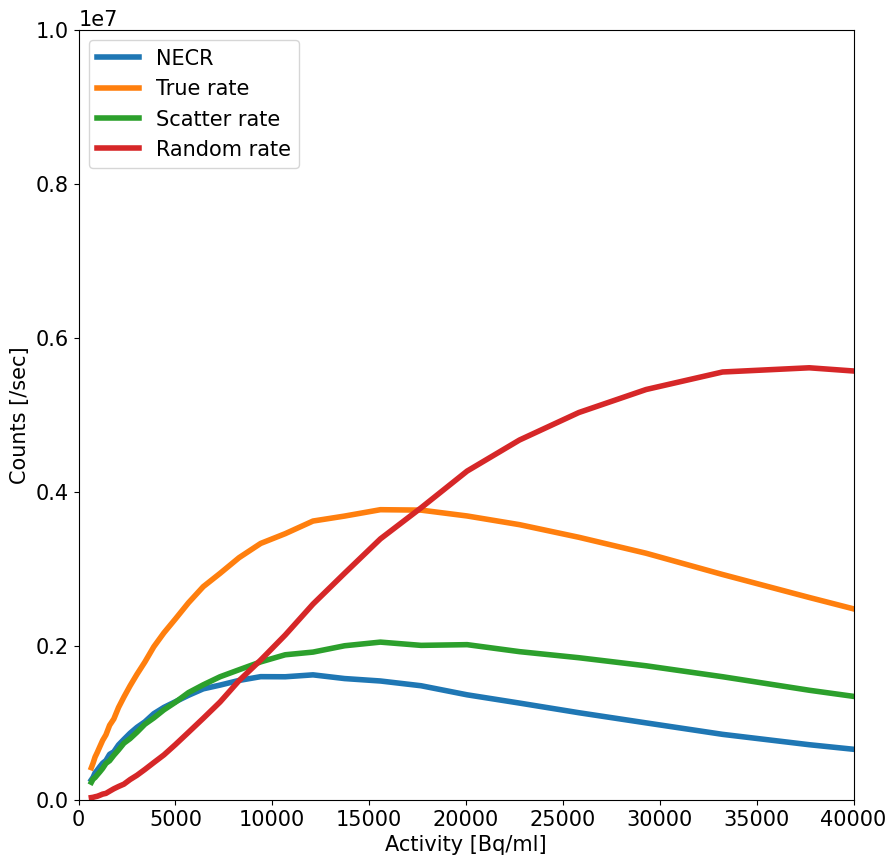

In [5]:
mpl.plot( activityAtTimeSiemens, necrAtTimeSiemens, label=labels[0], linewidth=4.0 )
mpl.plot( activityAtTimeSiemens, trueAtTimeSiemens, label=labels[1], linewidth=4.0 )
mpl.plot( activityAtTimeSiemens, scatterAtTimeSiemens, label=labels[2], linewidth=4.0 )
mpl.plot( activityAtTimeSiemens, randomAtTimeSiemens, label=labels[3], linewidth=4.0 )
mpl.legend( labels )
mpl.xlabel( "Activity [Bq/ml]" )
mpl.xlim( [ 0, 40000 ] )
mpl.ylim( [ 0, 10000000 ] )
mpl.ylabel( "Counts [/sec]" )
mpl.gcf().set_size_inches(10, 10)
mpl.show()

Clearly the simulation can give value estimates that are reasonable, but far from an exact recreation of experimental data. Given the simplified detector geometry, data readout, and analysis methods, this is to be expected

Most importantly, the simulation is a self-consistent environment to assess the relative (rather than absolute) performance of different detectors.